<a href="https://colab.research.google.com/github/epflyingzhang/ibm_data_science_capstone/blob/master/Capstone_Project_The_Battle_of_Neighborhoods_(Week_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - A Study of Neighborhoods in Zurich

In the project, we analyze the neighborhoods in Zurich using the location data from Foursquare and explore insights that can be helpful for residents, tourists and city planners. 

## Introduction and Business Problem

Zurich is the biggest city in Switzerland with a population of 0.4 million in the municipality area. Despite its small population, Zurich is among the world's largest financial centers. Zurich is also one of cities with the highest quality of life according to various surveys. Over 30% of population in Zurich do not hold Swiss citizenship, making it one of the most international cities in the world.  

The city of Zurich is splitted into 34 neighborhoods (German: "Quartier") for adminstrative purposes. What characteristics do different neighborhoods have? Which neighhood should I go to if I want to hang out in bars or clubs? Which neighboods are similar, and in what way? The answers to these questions could help tourists decide how to explore the city; residents choose a neighborhood to live; and city planners make cecisions.  

We approach these problems in the following way. First of all, we collect data that charaterize neighborhoods. Then, we use exploratory analysis to gain some initial insights from the data. After that, we make cluster analysis on neighboods. Finally, we discuss our findings and propose next steps for this analysis.  

## Data
In order to answer the questions above, we need the following data:

- Geospatial data of neighborhoods in Zurich. 
We can obtain this dataset (GEOJSON) from the [Geodata Portal of Zurich](https://www.stadt-zuerich.ch/geodaten/download/Statistische_Quartiere)

- Venue data from Foursquare by category (e.g. restaruants, bars & clubs, cultural spots, offices, train stations)

[//]: # (Zurich Tourism data: https://zt.zuerich.com/en/open-data)

### Data Collection

Import all libraries needed for this notebook

In [116]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import json
import pickle

import geopy.distance
import folium # plotting library
import shapely.geometry # for detecting if a point is inside a polygon

import matplotlib.pyplot as plt
import os

print('Libraries imported.')

Libraries imported.


Change current working directory to google drive folder

In [21]:
# Google Drive directory
newpath = r'/content/drive/My Drive/Colab Files/2020 Data Science Capstone' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
os.chdir(newpath)
os.getcwd()

'/content/drive/My Drive/Colab Files/2020 Data Science Capstone'

#### GEOJSON Zurich


Load GEOJSON file of Zurich neighborhoods

In [32]:
# get coordinates of Zurich city center
address = 'Zurich City, Switzerland'

geolocator = geopy.geocoders.Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print("Coordinates (latitude, longitude) of Zurich city center are: {}, {}".format(latitude, longitude))

# load GEOJSON file
file_name = 'Statistische_Quartiere_geojson'
with open(file_name) as f:
  geo_data = json.load(f)

Coordinates (latitude, longitude) of Zurich city center are: 47.3723941, 8.5423328


In [0]:
# take a brief look at geo_data
print("Total number of neighborhoods:", len(geo_data['features']))
nb_names = [(x['properties']['kname'], x['properties']['qname']) for x in geo_data['features']]
nb_names

In [34]:
# plot map
map_zuri = folium.Map(location=[latitude, longitude], zoom_start=13)
map_zuri
# add geojson
folium.Choropleth(
  geo_data=geo_data,
  name='choropleth',
  # data=state_data,
  # columns=['', ''],
  key_on='feature.properties.qname',
  fill_color='yellow',
  fill_opacity=0.2,
  # fill=False,
  line_opacity=1.0,
  line_color='blue',
  # legend_name=''
  ).add_to(map_zuri)
map_zuri



#### [Open Data Portal of Zürich Tourism](https://zt.zuerich.com/en/open-data)

In [0]:
# # download data from Zurich Tourism
# !wget 'https://www.zuerich.com/en/data/gastronomy/restaurants' -O zuri_tour/restaurants.json
# !wget 'https://www.zuerich.com/en/data/gastronomy/nightlife/bars+%7C%7C+lounges' -O zuri_tour/bars.json 
# !wget 'https://www.zuerich.com/en/data/place/culture' -O zuri_tour/culture.json 
# !wget 'https://www.zuerich.com/en/data/gastronomy/nightlife/clubs+%7C%7C+discos' -O zuri_tour/clubs.json 
# !wget 'https://www.zuerich.com/en/data/place/attractions' -O zuri_tour/attractions.json 
# !wget 'https://www.zuerich.com/en/data/accommodation' -O zuri_tour/accommodation.json 
## !wget 'https://www.zuerich.com/en/data/gastronomy/restaurants/cuisine/asian'

In [31]:
# take a look at data inside
with open('zuri_tour/culture.json') as f:
  tourism = json.load(f)

print("{} items are listed in the Zurich Tourism data".format(len(tourism)))
print("Take a look at one:\n")
print(tourism[0])
print(tourism[0].keys())

# list different categories
print([x['category'] for x in tourism])
print(set([x['category'][0] for x in tourism]))  

# geo coordinates
print(tourism[0]['geo'])  # -> {'latitude': '47.318394962017', 'longitude': '8.550952257797'}

142 items are listed in the Zurich Tourism data
Take a look at one:

{'id': '545927', '@context': 'https://schema.org/', '@type': 'Place', 'copyright': {'en': 'Zurich Tourism www.zuerich.com', 'de': 'Zürich Tourismus www.zuerich.com', 'it': 'Zürich Tourismo www.zuerich.com', 'fr': 'Zürich Tourisme www.zuerich.com'}, 'cc': 'BY-SA', 'category': ['Culture', 'Museums', 'Shopping', 'Food & Delicacy'], 'name': {'de': 'Lindt Home of Chocolate', 'en': 'Lindt Home of Chocolate', 'fr': 'Lindt Home of Chocolate', 'it': 'Lindt Home of Chocolate'}, 'disambiguatingDescription': {'de': 'Ein Traum für alle Schokolade-Fans: Die multimediale Erlebniswelt am Zürichsee.', 'en': 'A dream for all chocolate fans: near Lake Zurich, Lindt invites visitors to a multimedia experience world. \r\n', 'fr': 'Le rêve des amateurs de chocolat : l’espace interactif multimédia au bord du lac de Zurich. \r\n', 'it': 'Un sogno per tutti gli amanti del cioccolato: il mondo multimediale in riva al Lago di Zurigo.\r\n'}, 'de

Observations:  
- 526 restaurants, can be further grouped into Asia, Itatly, etc.
- 104 attractions
- 142 cultural sites, some overlap with attractions
- 188 hotels
- downloadable as json file; including lat&log data

#### Foursquare data

Let's look at **Foursquare** data now.

The search function returns max. 50 results at at time. Therefore, it is necessary to split the whole Zurich region into smaller cells and make multiple calls in order to gather all venue data. We can also split the calls by venue category. 

First, we pull out the category list and do some mapping.   
[This page](https://developer.foursquare.com/docs/build-with-foursquare/categories/) gives the hierachical tree of categories.    
This same information can also be obtained via API:

In [0]:
# Foursqaure credentials
CLIENT_ID = 'QEPQ03NLWD2WHE1ILZ5AUJA3JNSXEI2DJWJNKHOU133HORCY' # your Foursquare ID
CLIENT_SECRET = 'GEGJUS2TFG3DQOASUYQDUJTNWTTX2IMN5RNASS5LUOIU3YMY' # your Foursquare Secret
VERSION = '20200330'
LIMIT = 50  # max number of search results 

In [53]:
# pull out hierachical category tree from foursquare
url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)
file_name = 'categories.json'
try:
  with open(file_name, 'r') as f:
   fs_categories = json.load(f)
   print("load successful")
except Exception as e:
  print(e, "\ncategory file not found! re-download from foursquare.")
  results = requests.get(url).json()
  # dump data in a json file
  with open(file_name, 'w') as fp:
      json.dump(results, fp)
  print("download successful")

load successful


In [54]:
# level one categories
cat_l1 = [(x['name'], x['id']) for x in results['response']['categories']]
print(cat_l1)
# level two inside 'Food'
cat_l2_food = [(x['name'], x['id']) for x in results['response']['categories'][3]['categories']]
print(cat_l2_food)

[('Arts & Entertainment', '4d4b7104d754a06370d81259'), ('College & University', '4d4b7105d754a06372d81259'), ('Event', '4d4b7105d754a06373d81259'), ('Food', '4d4b7105d754a06374d81259'), ('Nightlife Spot', '4d4b7105d754a06376d81259'), ('Outdoors & Recreation', '4d4b7105d754a06377d81259'), ('Professional & Other Places', '4d4b7105d754a06375d81259'), ('Residence', '4e67e38e036454776db1fb3a'), ('Shop & Service', '4d4b7105d754a06378d81259'), ('Travel & Transport', '4d4b7105d754a06379d81259')]
[('Afghan Restaurant', '503288ae91d4c4b30a586d67'), ('African Restaurant', '4bf58dd8d48988d1c8941735'), ('American Restaurant', '4bf58dd8d48988d14e941735'), ('Asian Restaurant', '4bf58dd8d48988d142941735'), ('Australian Restaurant', '4bf58dd8d48988d169941735'), ('Austrian Restaurant', '52e81612bcbc57f1066b7a01'), ('BBQ Joint', '4bf58dd8d48988d1df931735'), ('Bagel Shop', '4bf58dd8d48988d179941735'), ('Bakery', '4bf58dd8d48988d16a941735'), ('Bangladeshi Restaurant', '5e179ee74ae8e90006e9a746'), ('Belgian

Let's see what types of venues are near Zurich center


In [0]:
condition_str = "ll={},{}&radius=500&limit=50".format(latitude, longitude)
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&{}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, condition_str)
r = requests.get(url).json()

items = r['response']['groups'][0]['items']
cats = [x['venue']['categories'][0]['name'] for x in items]
cats

Let's use the search function to pull out the top 50 resturants near Zurich center.

In [73]:
# auxilary function
def fs_search(condition_str):
  url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&{}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, condition_str)
  return requests.get(url).json()

# do a first search around the city center
cat_id = '4d4b7105d754a06374d81259' # Food
r = fs_search("ll={},{}&categoryId={}&radius={}&limit={}".format(latitude, longitude,cat_id, 50, 50))  
print(len(r['response']['venues']))
print(r['response']['venues'][0])
all_cats = pd.Series([x['categories'][0]['name'] for x in r['response']['venues']]).value_counts()
print([(x['id'], x['name'], x['categories'][0]['name'], x['categories'][0]['id'], x['location']['lat'], x['location']['lng']) for x in r['response']['venues']])
print(all_cats)


19
{'id': '4be416f1cf200f472e72113c', 'name': 'Gran Café Motta', 'location': {'address': 'Limmatquai 66', 'crossStreet': 'Rathaus', 'lat': 47.37234591508398, 'lng': 8.54275444911584, 'labeledLatLngs': [{'label': 'display', 'lat': 47.37234591508398, 'lng': 8.54275444911584}], 'distance': 32, 'postalCode': '8001', 'cc': 'CH', 'city': 'Zürich', 'state': 'Zürich', 'country': 'Schweiz', 'formattedAddress': ['Limmatquai 66 (Rathaus)', '8001 Zürich', 'Schweiz']}, 'categories': [{'id': '4bf58dd8d48988d16d941735', 'name': 'Café', 'pluralName': 'Cafés', 'shortName': 'Café', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_', 'suffix': '.png'}, 'primary': True}], 'venuePage': {'id': '94120877'}, 'referralId': 'v-1586181347', 'hasPerk': False}
[('4be416f1cf200f472e72113c', 'Gran Café Motta', 'Café', '4bf58dd8d48988d16d941735', 47.37234591508398, 8.54275444911584), ('4b1fbfd6f964a520ab2824e3', 'Rathaus Café', 'Café', '4bf58dd8d48988d16d941735', 47.37227545206023, 8.5425501503931

We use a recursive algorithm to gather all venues of a certain category in Zurich.  
1. initialize bbox for search  ((sw_lat, sw_lon), (ne_lat, ne_lon))
2. search within bbox, 

  if returned results >= 50:
      1. splite bbox into four smaller bboxes
      2. go back to 2.

  else:
      store result

In [0]:
# recursive search function

class Bbox:
  def __init__(self, sw_lat, sw_lon, ne_lat, ne_lon):
    self.sw_lat = sw_lat
    self.sw_lon = sw_lon
    self.ne_lat = ne_lat
    self.ne_lon = ne_lon

  @property
  def mid_lat(self):
    return (self.sw_lat + self.ne_lat) / 2

  @property
  def mid_lon(self):
    return (self.sw_lon + self.ne_lon) / 2

  @property
  def diagonal_len(self): # diagnoal length in meters
    # import geopy.distance
    coords_1 = (self.sw_lat, self.sw_lon)
    coords_2 = (self.ne_lat, self.ne_lon)
    return geopy.distance.vincenty(coords_1, coords_2).meters


def split_bbox_by_mid(bbox: Bbox):
    mid_lat = (bbox.sw_lat + bbox.ne_lat) / 2
    mid_lon = (bbox.sw_lon + bbox.ne_lon) / 2
    bbox1 = Bbox(bbox.sw_lat, bbox.sw_lon, mid_lat, mid_lon)  # bottom right
    bbox2 = Bbox(mid_lat, mid_lon, bbox.ne_lat, bbox.ne_lon)  # upper left
    bbox3 = Bbox(bbox.sw_lat, mid_lon, mid_lat, bbox.ne_lon)  # bottom left
    bbox4 = Bbox(mid_lat, bbox.sw_lon, bbox.ne_lat, mid_lon)  # upper right
    return [bbox1, bbox2, bbox3, bbox4]
  

# initialize global variable
recursive_output = []
list_bbox = []
query_count = 0

def recursive_search(bbox: Bbox, categoryId):
  global recursive_output  # declare global variable
  global query_count

  print("running the {}th query...".format(query_count + 1))
  # search the circular area with center of the bbox as center and half of diagonal lenght as radius
  tmp = fs_search(condition_str="ll={},{}&radius={}&categoryId={}&limit={}".format(bbox.mid_lat, bbox.mid_lon, bbox.diagonal_len / 2, categoryId, LIMIT))

  query_count += 1
  nr = len(tmp['response']['venues'])
  print(nr, " venues returned")
  print(nr>=LIMIT)
  if nr >= LIMIT:
    print("break down into smaller cells")
    new_bboxes = split_bbox_by_mid(bbox)
    for b in new_bboxes:
      recursive_search(b, categoryId)
  else:
    # append output to global variable
    recursive_output.append(tmp)
    list_bbox.append(bbox)

Let's use the class and function defined above to pull out venue data. 

In [121]:
dict(cat_l1)

{'Arts & Entertainment': '4d4b7104d754a06370d81259',
 'College & University': '4d4b7105d754a06372d81259',
 'Event': '4d4b7105d754a06373d81259',
 'Food': '4d4b7105d754a06374d81259',
 'Nightlife Spot': '4d4b7105d754a06376d81259',
 'Outdoors & Recreation': '4d4b7105d754a06377d81259',
 'Professional & Other Places': '4d4b7105d754a06375d81259',
 'Residence': '4e67e38e036454776db1fb3a',
 'Shop & Service': '4d4b7105d754a06378d81259',
 'Travel & Transport': '4d4b7105d754a06379d81259'}

In [0]:
# Start with the area defined by bbox
geo_zuri = geo_data['bbox']
bbox_zuri = Bbox(
    geo_zuri[1], 
    geo_zuri[2],
    geo_zuri[3],
    geo_zuri[0]
    )

# mapping categoryID
CAT_MAP = {
    'food': '4d4b7104d754a06370d81259', # take
    'arts_entertainment': '4d4b7104d754a06370d81259', # take
     'shop': '4d4b7105d754a06378d81259',
     'transport': '4d4b7105d754a06379d81259',
    # 'event': '4d4b7105d754a06373d81259',  # not take
    # 'school': '4bf58dd8d48988d13b941735',   # not take
    # 'tram_station': '52f2ab2ebcbc57f1066b8b51',
    # 'bus_stop': '52f2ab2ebcbc57f1066b8b4f',
    # 'bus_station': '4bf58dd8d48988d1fe931735',
    # 'outdoor': '4d4b7105d754a06377d81259',  # not take
    'office': '4bf58dd8d48988d124941735',  # take
    # 'residence': '4e67e38e036454776db1fb3a',  # not take
    'nightlife':  '4d4b7105d754a06376d81259', # take
}

category_name = 'transport'    # ['food', 'arts_entertainment', 'school', 'tram_station', 'bus_stop', 'outdoor']
food_category_id = CAT_MAP[category_name]   
      
# initialize global variable
recursive_output = []
list_bbox = []
query_count = 0

# try read from plk file
file_Name_1 = "foursquare/recursive_zuri_{}.plk".format(category_name)
file_Name_2 = "foursquare/bbox_zuri_{}.plk".format(category_name)

try:
  with open(file_Name_1, 'rb') as f:
    recursive_output = pickle.load(f)
  with open(file_Name_2, 'rb') as f:
    list_bbox = pickle.load(f)
  print("data loaded from plk files.")

except:
  print("no plk files available, download from foursquare")
  recursive_search(bbox_zuri, food_category_id)

  # dump output as plk files
  with open(file_Name_1,'wb') as f:
    pickle.dump(recursive_output,f)   

  with open(file_Name_2,'wb') as f:
    pickle.dump(list_bbox,f) 

In [126]:
# take a quick look
sum([len(x['response']['venues']) for x in recursive_output])


667

Clean relevant Foursquare data.

In [127]:
df = None
for cat in CAT_MAP:
  file_name = "foursquare/recursive_zuri_{}.plk".format(cat)
  with open(file_name, 'rb') as f:
    recursive_output = pickle.load(f)
    
  # convert json style to data frame and remove duplicates
  list_venues = [item for sublist in recursive_output for item in sublist['response']['venues']]

  df_tmp = pd.DataFrame([(x['id'], x['name'], x['categories'][0]['name'], x['categories'][0]['id'], x['location']['lat'], x['location']['lng']) for x in list_venues])
  df_tmp.columns = ['id', 'name', 'category', 'category_id', 'latitude', 'longitude']
  df_tmp.drop_duplicates(['id'], ignore_index=True, inplace=True)
  df_tmp['search_category'] = cat
  df_tmp['search_category_id'] = CAT_MAP[cat]
  print("total number of {} places: ".format(cat), len(df_tmp))
  df = df_tmp.copy() if df is None else df.append(df_tmp, ignore_index=True)

# it is possible that one venue appears in multiple categories, let's keep only one category for simplicity
df.drop_duplicates(['id'], ignore_index=True, inplace=True)
print(df['search_category'].value_counts())
df.head()

total number of food places:  3053
total number of arts_entertainment places:  612
total number of shop places:  1726
total number of transport places:  404
total number of office places:  933
total number of nightlife places:  1000
food                  3053
shop                  1680
office                 908
nightlife              832
arts_entertainment     604
transport              397
Name: search_category, dtype: int64


id  ...        search_category_id
0  4e0a32f1d164028d170c959b  ...  4d4b7104d754a06370d81259
1  5be9c2d1cad1b600397fe193  ...  4d4b7104d754a06370d81259
2  4c8a5eb59ef0224be2305a7b  ...  4d4b7104d754a06370d81259
3  4b058887f964a520cccb22e3  ...  4d4b7104d754a06370d81259
4  4db140975da32cf2df57c5ea  ...  4d4b7104d754a06370d81259

[5 rows x 8 columns]

After comparing venue data from Foursquare with Zurich Tourism, we find Foursquare data cover a larger list of venues and more detailed category label. Therefore, we decide to **use Foursquare data only** for this analysis. 

### Data Preparation

First of all, we need to map venues to neighborhood according to coordinates. We use shapely package to help us determine whether a point is inside a polygon.

In [0]:
# aux function: given a polygon, and a pair of coordinates, determine whether this location is inside the polygon or not

def find_neighborhood(lo, la):
  point = shapely.geometry.Point(lo, la)
  for i in range(len(geo_data['features'])):
    p_coordinates = [ tuple(x) for x in geo_data['features'][i]['geometry']['coordinates'][0] ]
    qname = geo_data['features'][i]['properties']['qname']
    p = shapely.geometry.Polygon(p_coordinates)
    if p.contains(point):
      return qname
  return None  # if no neighborhood is found


In [134]:
# to avoid running this algo everytime, let's save df as a plk file
file_df_plk = 'df.plk'
try:
  with open(file_df_plk, 'rb') as f:
    df = pickle.load(f)
except:
  # add neighborhood column (this takes a few seconds to run)
  df['neighborhood'] = df.apply(lambda x: find_neighborhood(x['longitude'], x['latitude']), axis=1)
  # remove rows outside of Zurich
  df.dropna(subset=['neighborhood'], inplace=True)
  with open(file_df_plk, 'wb') as f:
    pickle.dump(df, file=f)

print("remaining number of venues: ", len(df))
df.head(10)


remaining number of venues:  6318


id  ... neighborhood
34  532f2b7c498e73153ddc093d  ...      Witikon
46  4c9bca7203133704c1704fd5  ...      Weinegg
47  5834835e2980db136afe0f51  ...      Witikon
48  5c59722386bc49002cc75ba6  ...    Mühlebach
49  5807505d38fa70c74a973893  ...    Mühlebach
50  52281f89bce6b3f26bbb40bb  ...      Weinegg
51  5220679911d296a1baff217f  ...    Mühlebach
52  4cea20a1f3bda143bc19c4e4  ...    Mühlebach
53  5148a59ae4b0f4108f194391  ...      Weinegg
54  4c91e46357e5b60c4f3a641c  ...    Mühlebach

[10 rows x 9 columns]

We end up with a data frame of 6318 rows, each representing a unique venue in Zurich. The columns contain geo-coordinates, categories (two-levels) and the neighborhoods in which they are located.

## Analysis


### Exploratory analysis and visualization

In [118]:
df['category'].value_counts()

Office                  531
Bar                     274
Italian Restaurant      264
Restaurant              255
Café                    246
                       ... 
Track Stadium             1
Supermarket               1
Farm                      1
Cambodian Restaurant      1
School                    1
Name: category, Length: 246, dtype: int64

In [119]:
df['neighborhood'].value_counts()

Langstrasse             458
City                    328
Escher Wyss             324
Rathaus                 277
Altstetten              253
Enge                    244
Gewerbeschule           243
Alt-Wiedikon            238
Oerlikon                220
Sihlfeld                209
Hochschulen             189
Hard                    166
Unterstrass             165
Seefeld                 157
Lindenhof               151
Hottingen               109
Mühlebach               106
Seebach                  99
Werd                     91
Wollishofen              81
Albisrieden              80
Wipkingen                78
Oberstrass               77
Höngg                    61
Fluntern                 50
Affoltern                48
Weinegg                  44
Schwamendingen-Mitte     41
Hirslanden               37
Friesenberg              33
Witikon                  13
Saatlen                  10
Leimbach                  7
Hirzenbach                7
Name: neighborhood, dtype: int64

Now that we have all venues data. Let's visulize the data.

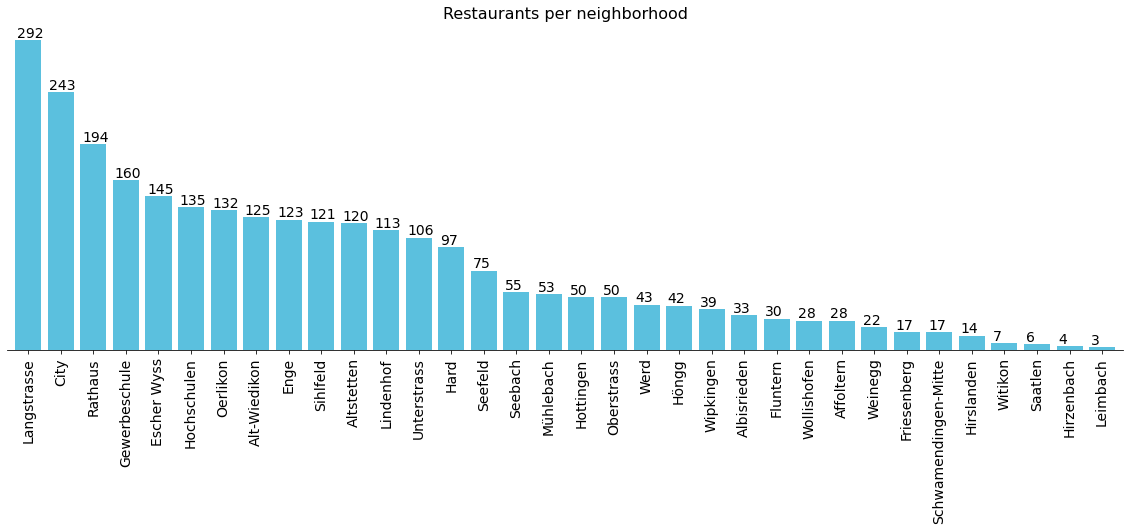

In [0]:
# First, let's make a bar plot
s = df['neighborhood'].value_counts()

ax = s.plot(kind='bar', figsize=(20,6), width=0.8, color='#5bc0de')

ax.set_title("Restaurants per neighborhood", size=16)
ax.tick_params(axis='x', labelsize=14)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_yaxis().set_visible(False)

for idx in range(len(s)):
  label = '{}'.format(s.values[idx]) 
  y = s.iloc[idx] + 3
  x = idx - 0.35  # manual adjust after try and error
  ax.annotate(label, xy=[x, y], size=14)


We can also make a choropleth map:

In [0]:
# Choropleth by number of restaurants
df_neighborhood = pd.DataFrame(s).reset_index()
df_neighborhood.columns = ['neighborhood', 'number_restaurants']
df_neighborhood.head
# plot map
map_zuri = folium.Map(location=[latitude, longitude], zoom_start=13)

# add geojson
folium.Choropleth(
  geo_data=geo_data,
  name='choropleth',
  data=df_neighborhood,
  columns=['neighborhood', 'number_restaurants'],
  key_on='feature.properties.qname',
  fill_color='YlOrRd',
  fill_opacity=0.8,
  # fill=False,
  line_opacity=1.0,
  line_color='blue',
  legend_name='Number of Restaurants'
  ).add_to(map_zuri)

# add Maker for restaurants
folium.Marker([latitude, longitude], popup='City Center').add_to(map_zuri)
for index, row in df.iterrows():
  lat = row['latitude']
  lon = row['longitude']
  colors_dict = {
      'Chinese Restaurant': 'blue',
      'Thai Restaurant': 'green',
      'Bakery': 'red',
      'Italian Restaurant': 'black',
      'Swiss Restaurant': 'purple'
  }

  pop_up_text = row['name']
  color = colors_dict[row['category']] if row['category'] in colors_dict else 'grey'
  folium.CircleMarker([lat, lon], radius=3, color=color, fill=True, fill_color=color, fill_opacity=1.0
                      ).add_to(map_zuri)
map_zuri



Let's have a look at the categories.

Italian Restaurant               263
Restaurant                       255
Café                             242
Swiss Restaurant                 232
Bakery                           134
Pizza Place                       91
Asian Restaurant                  79
Coffee Shop                       78
Thai Restaurant                   72
Food Truck                        62
Indian Restaurant                 55
Fast Food Restaurant              47
Snack Place                       45
Vegetarian / Vegan Restaurant     41
Burger Joint                      40
Chinese Restaurant                39
French Restaurant                 38
Sandwich Place                    36
Bistro                            33
Sushi Restaurant                  32
Middle Eastern Restaurant         30
Ice Cream Shop                    29
Cafeteria                         28
Japanese Restaurant               27
Mediterranean Restaurant          27
BBQ Joint                         24
Turkish Restaurant                24
D

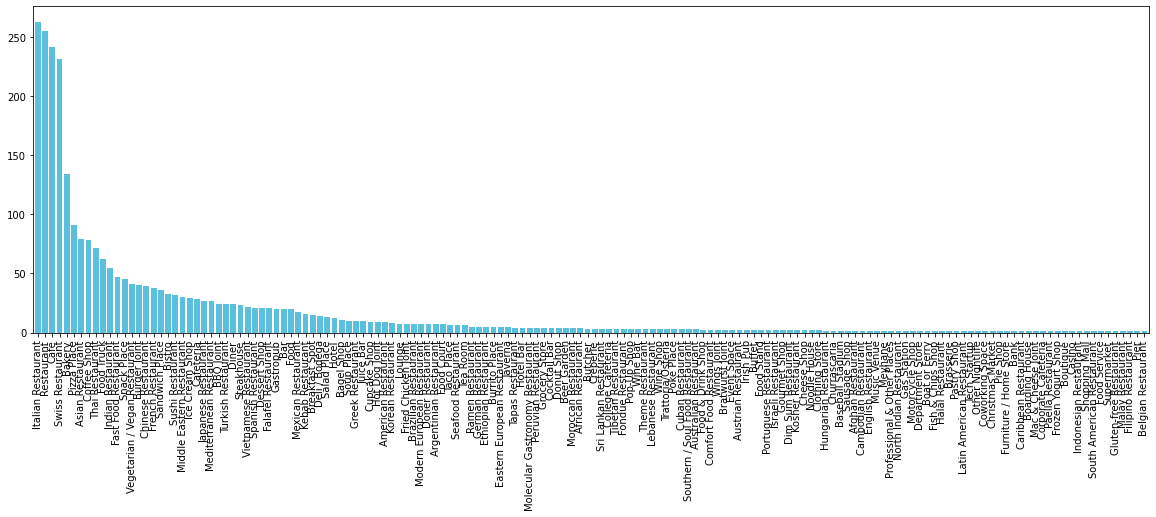

In [0]:
s_category = df['category'].value_counts()
ax = s_category.plot(kind='bar', figsize=(20,6), width=0.8, color='#5bc0de')
s_category.head(60)

**Next steps**  
Take all restaurants within 10km from Zurich center from Foursquare.

1. map categories  
1. bar chart by category

==> answer first question: where should one go to find some good restaurant? 


1. get population/household data per neighborhood

1. how location (infrastructure (train station, university), attractions (church, monument, museem , no. shops,  influences restaurant density? Which one is the most important factor?

We can anser the following questions

why some neighboorhoods have higher density of restaurant, some lower. 
can we model it out and determine which neighboorhood has high / lower competition? 

1. we need to calculate density (nr./area size)

1. public transportation (nr. train, tram, bus stops)
4. entertainment: nr. of Movie Theater, music
5. culture: nr. of museem, galery
3. nr. of office (4bf58dd8d48988d124941735)
2. line-distance to center
5. nr. household / population
6



1. do some correlation analysis. 
2. For city planner. 

Regression error analysis.

Future work: forecast next popular neighborhood, based on planned infrastructure and 

## Methodology

## Results

## Discussion

## Conclusion